In [36]:
import numpy as np
import xarray as xr
import xesmf
# https://github.com/raphaeldussin/HCtFlood
from HCtFlood import kara as flood
import sys
import numpy as np
import xarray
import os.path

era5_dict = {'ERA5_2m_temperature':'t2m',
             'ERA5_sea_ice_cover':'siconc',
            'ERA5_10m_u_component_of_wind':'u10',
            'ERA5_sea_surface_temperature':'sst',
            'ERA5_10m_v_component_of_wind':'v10',
            'ERA5_surface_solar_radiation_downwards':'ssrd',
            'ERA5_surface_thermal_radiation_downwards':'strd',
            'ERA5_total_rain_rate':'trr',
            'ERA5_mean_sea_level_pressure':'msl',
            'ERA5_2m_specific_humidity':'huss'}

def interp_landmask(landmask_file):
    landmask = xr.open_dataset(landmask_file).rename({'x': 'lon', 'y': 'lat'})
    lon_centers = landmask['lon'].values
    lat_centers = landmask['lat'].values
    lon_corners = 0.25 * (
        lon_centers[:-1, :-1]
        + lon_centers[1:, :-1]
        + lon_centers[:-1, 1:]
        + lon_centers[1:, 1:]
    )
    # have to add 2 extra rows/columns to the array becuase we remove 1 when we calculate the corners from the center values
    lon_corners_exp = np.full((lon_corners.shape[0]+2,lon_corners.shape[1]+2),np.nan)
    lon_corners_exp[:-2,:-2] = lon_corners
    landmask['lon_b'] = xr.DataArray(data=lon_corners_exp, dims=("nyp", "nxp"))
    lon_b = landmask['lon_b']
    filled = lon_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")
    filled_lon = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
    
    # interpolate latitidue corners from latitude cell centers
    lat_corners = 0.25 * (
        lat_centers[:-1, :-1]
        + lat_centers[1:, :-1]
        + lat_centers[:-1, 1:]
        + lat_centers[1:, 1:]
    )

    # create expanded latitude corners array and then interpolate the values so our nxp, nyp = nx+1, ny+1
    lat_corners_exp = np.full((lat_corners.shape[0]+2,lat_corners.shape[1]+2),np.nan)
    lat_corners_exp[:-2,:-2] = lat_corners
    landmask['lat_b'] = xr.DataArray(data=lat_corners_exp, dims=("nyp", "nxp"))
    lat_b = landmask['lat_b']
    filled= lat_b.interpolate_na(dim='nyp',method='linear',fill_value="extrapolate")
    filled_lat = filled.interpolate_na(dim='nxp',method='linear',fill_value="extrapolate")
    landmask['lon_b'] = filled_lon
    landmask['lat_b'] = filled_lat
    landmask['mask'] = landmask['mask'].where(landmask['mask'] != 1)
    
    return landmask
    
    
def interp_era5(era5_file, era5_var):
    era = xr.open_dataset(era5_file)
    era = era.rename({'longitude': 'lon', 'latitude': 'lat'})
    if "lon" in era.coords:
        era = era.assign_coords(lon=(np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)))
        era = era.swap_dims({'lon' : 'nx'})    
        era = era.swap_dims({'lat' : 'ny'}) 
    if "lon" in era.data_vars:
        era['lon'].values =  np.where(era['lon'].values > 180., era['lon'].values - 360, era['lon'].values)

    lon_centers = era['lon'].values
    lat_centers = era['lat'].values
    # To use conservative regidding, we need the cells corners. 
    # Since they are not provided, we are creating some using a crude approximation. 
    lon_corners = 0.25 * (
        lon_centers[:-1]
        + lon_centers[1:]
        + lon_centers[:-1]
        + lon_centers[1:]
    )

    lat_corners = 0.25 * (
        lat_centers[:-1]
        + lat_centers[1:]
        + lat_centers[:-1]
        + lat_centers[1:]
    )

    # trim down era by 1 cell
    era = era.isel(nx=slice(1,-1), ny=slice(1,-1))
    da_era_var=era[era5_var].values
    
    # add nxp and nyp dimensions for the lat/lon corners to latch onto
    era = era.expand_dims({'nyp':(len(era.lat) + 1)})
    era = era.expand_dims({'nxp':(len(era.lon) + 1)})

    # add the lat/lon corners as data variables,
    era['lat_corners'] = xr.DataArray(data=lat_corners, dims=("nyp"))
    era['lon_corners'] = xr.DataArray(data=lon_corners, dims=("nxp"))
    # drop the variable
    era = era.drop_vars(era5_var)
    era[era5_var] = xr.DataArray(data=da_era_var, dims=("time" ,"lat", "lon"))
    
    # create meshgrids for center and corner points so we can co-locate with landmask meshgrids.
    lon2d, lat2d = np.meshgrid(era.lon.values, era.lat.values)
    lon2d_b, lat2d_b = np.meshgrid(era.lon_corners.values, era.lat_corners.values)
    
    # assign coordinates now that we have our corner points
    era = era.assign_coords({"lon" : (("ny", "nx"), lon2d)})
    era = era.assign_coords({"lat" : (("ny", "nx"), lat2d)})
    era = era.assign_coords({"lon_b" : (("nyp", "nxp"), lon2d_b)})
    era = era.assign_coords({"lat_b" : (("nyp", "nxp"), lat2d_b)})
    
    return era

def flood_era5_data(era5_file,era5_var,landmask_file, outfile, reuse_weights=False):
 # interp landmask
    landmask = interp_landmask(landmask_file)

    #interp era
    era = interp_era5(era5_file, era5_var)
    
    # regrid conservatively: conservative does the best, especially along fine points
    regrid_domain = xesmf.Regridder(landmask, era, 'conservative', 
                                    periodic=False, reuse_weights=reuse_weights, filename='regrid_domain.nc')
    land_regrid = regrid_domain(landmask.mask)
    land_regrid=land_regrid.expand_dims(time=era['time'])
    land_regrid=land_regrid.transpose("time", "ny", "nx")
    #print(land_regrid)
    era=era.transpose("time", "lat", "lon", "ny", "nx", "nyp", "nxp")
    # cut era based on regridded landmask
    era_cut = era[era5_var].where(land_regrid.values == 0)

    # flood our cut out points
    flooded = flood.flood_kara(era_cut)
    flooded = flooded.isel(z=0).drop('z')
    #print(flooded)
    # note that this current version of this code will cut down your era5 domain by 2 rows/colse)
    era = xr.open_dataset(era5_file)
    era = era.isel(longitude=slice(1,len(era.longitude)-1), latitude=slice(1,len(era.latitude)-1))
    era=era.transpose("time", "latitude", "longitude")
    
    era[era5_var].values = flooded.values    
    
    if era5_var=='ssrd' or era5_var=='strd':
        # convert radiation from J/m2 to W/m2: https://confluence.ecmwf.int/pages/viewpage.action?pageId=155337784
        era[era5_var].values = era[era5_var].values/3600
        era[era5_var].attrs['units'] = 'W m-2'
    if era5_var=='huss':
        era[era5_var].attrs['dtype'] = 'float64'
        era[era5_var].attrs['standard_name'] = 'specific_humidity'
        era[era5_var].attrs['long_name'] = 'Near-Surface Specific Humidity'
        era[era5_var].attrs['coordinates'] = 'height'
        era[era5_var].attrs['units'] = '1'
        era['height'] = 2.0
        era['height'].attrs['units'] = "m"
        era['height'].attrs['axis'] = "Z"
        era['height'].attrs['positive'] = "up"
        era['height'].attrs['long_name'] = "height"
        era['height'].attrs['standard_name'] = "height"
    era.to_netcdf(outfile,format='NETCDF4_CLASSIC', unlimited_dims='time')
    era.close()


def main():
    landmask_file = '/glade/work/jsimkins/gridInfo/nwa25/land_mask.nc'
    padded_dir = '/glade/scratch/jsimkins/ERA5/padded/'
    flood_dir = '/glade/scratch/jsimkins/ERA5/flooded/'
    era5_year = 1996
    keys_list=list(era5_dict)
    
    for f in era5_dict.keys():
        reuse_weights=False
        era5_file = f"{padded_dir}/{f}_{era5_year}.nc"
        outfile = f"{flood_dir}/{f}_{era5_year}.nc"
        if f != keys_list[0]:
            reuse_weights=True
        
        if os.path.isfile(outfile) == False:
            print(f)
            flood_era5_data(era5_file=era5_file, era5_var=era5_dict[f],reuse_weights=reuse_weights,landmask_file=landmask_file,outfile=outfile)


if __name__ == '__main__':
    main()
    


In [ ]:
flood_era5_data(era5_file="ERA5_2m_temperature_1996.nc",era5_var="t2m",landmask_file="/glade/workdir/jsimkins/gridInfo/nwa25/land_mask.nc", outfile="/glade/scratch/jsimkins/ERA5/ERA5_2m_temperature_1996.nc")

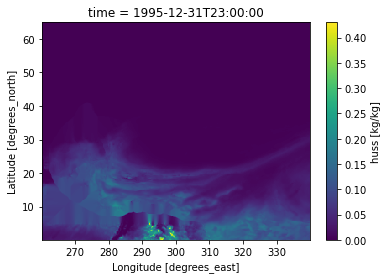

In [4]:
import xarray as xr
era=xr.open_dataset("/Users/james/Downloads/ERA5_2m_specific_humidity_1996.nc")
era5_var = 'huss'

era[era5_var][0].plot()

In [8]:
era[era5_var] = era[era5_var].where(era[era5_var] > 4e-16, 4e-16)
era[era5_var] = era[era5_var].where(era[era5_var] < 0.3, 0.3)

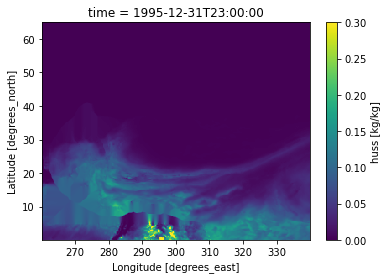

In [9]:
era[era5_var][0].plot()

In [ ]:
import xarray as xr

b=xr.open_dataset("ERA5_2m_specific_humidity_1996.nc")
b=b.where(b['huss'] >1, 0.001)
b=b.where(b['huss'] <1, 0.001)
b=b['huss'].astype('float64')
b.huss.encoding['_FillValue']=1.0e20
b.to_netcdf("test.nc",format='NETCDF4_CLASSIC', unlimited_dims='time')